# ECON 8185 - HW 2

João Lazzaro - santo279@umn.edu

Incomplete Version: As instructed in class, I skip the estimation part and do the CKM exercise with simulated data.

## Question 1

We'll consider the following Prototype model from Ellen's Homework 2, which is the same as CKM:

$$\max_{c_t,x_t,l_t} E \sum_{t=0}^\infty \beta^t \frac{\left(c_tl_t^\psi\right)^{1-\sigma}}{1-\sigma} N_t$$
S.T. 
$$ c_t +(1+\tau_{xt}x_t =r_t k_t +(1-\tau_{ht})w_t h_t + T_t$$
$$ N_{t+1} k_{t+1} = [(1-\delta)k_t+x_t]N_t$$
$$h_t+l_t =1$$
$$S_t = P S_{t-1}+Q\epsilon_t,\;\;S_t = [\ln z_t,\tau_{ht},\tau_{xt}, \ln g_t]$$
$$ c_t,x_t\geq0$$

Where $N_t = (1+\gamma_n)^t$ and firm tecnhology is $Y_t = K_t^\theta (Z_t L_t)^{1-\theta}$. $\gamma_z$ is the rate of labor-augmenting technical progress. The stochastic shocks hitting this economy affect technology, tax rates, and government spending and the stochastic processes are modeled as a VAR(1) process. The resource constraint is $Y_t=N_t(c_t +x_t +g_t)$. We must work with detrended variables, we should use "hat" variables, but typing this is time consuming so from now on all variables should be understood as detrended unless I say something about them.

The detrended FOC's of this model are:

$$c_t+(1+\gamma_z)(1+\gamma_n)k_{t+1} - (1-\delta)k_t+g_t = y_t =k_t^\theta(z_th_t)^{1-\theta}$$
$$\psi \frac{c_t}{1-h_t} = (1-\tau_{ht})(1-\theta)\left(\frac{k_t}{h_t}\right)^\theta z_t^{1-\theta}$$
$$c_t^{-\sigma}(1-h_t)^{\psi(1-\sigma)} (1+\tau_{xt})=\beta(1+\gamma_z)^{-\sigma}E_t c_{t+1}^{-\sigma} (1- h_{t+1})^{\psi(1-\sigma)}\left(\theta k_{t+1}^{\theta}(z_{t+1} h_{t+1})^{1-\theta} + (1-\delta)(1+\theta_{xt+1})\right)$$

Defining some parameters:

In [1]:
using Plots, NLsolve, ForwardDiff, DataFrames, LinearAlgebra, QuantEcon, Plots, Optim, Statistics
#Parameters:
δ = 0.0464   #depreciation rate
θ = 0.35  #capital share of output
β = 0.9722  #Discouting
σ = 1  #Elasticity of Intertemporal Substitution
ψ = 3    #Labor parameter
γn= 0.015    #Population growth rate
γz= 0.016   #Productivitu growth rate
gss = 0.01 #average g
τxss = 0.05 #average τx
τhss = 0.05 #average τh
zss = 0.0 #average z (z is in logs)


#Parameters to be estimated
ρg = 0.85
ρx = 0.73
ρh = 0.74
ρz = 0.98
ρzg= 0.0
ρzx = 0.0
ρzh = 0.0
ρhz = 0.0
ρhx = 0.0
ρhg = 0.0
ρxz = 0.0
ρxh = 0.0
ρxg = 0.0
ρgz = 0.0
ρgx = 0.0
ρgh = 0.0

σg= 0.02
σx = 0.01
σz = 0.02
σh = 0.01
σzg= 0.02
σzx = 0.001
σzh = 0.02
σhx = 0.01
σhg = 0.02
σxg = 0.02

ArgumentError: ArgumentError: Package QuantEcon not found in current path:
- Run `import Pkg; Pkg.add("QuantEcon")` to install the QuantEcon package.


Substituting for $c$, we get an euqation for $k$, and one for $h$. Below, I find the Steady State values:


In [2]:
#Function with the FOCs
zss = exp(zss)

function SS!(eq,vector::Vector)
    k,h, c= vector
    eq[1]=k/h-((1+τxss)*(1-β*(1+γz)^(-σ)*(1-δ))/(β*(1+γz)^(-σ)*θ*zss^(1-θ)) )^(1/(θ-1))
    eq[2]=c-( (k/h)^(θ-1)*zss^(1-θ) -(1+γz)*(1+γn)+1-δ)*k+gss
    eq[3]=ψ*c-( (1-τhss)*(1-θ)*(k/h)^θ *zss^(1-θ))*(1-h)
end

SteadyState = nlsolve(SS!, [3,0.25,.4],ftol = :1.0e-20)
kss,hss,css = SteadyState.zero

UndefVarError: UndefVarError: zss not defined

In [3]:
    #GDP
    yss = kss^(θ)*(zss*hss)^(1-θ)
    xss = (1+γz)*(1+γn)*kss-(1-δ)*kss

UndefVarError: UndefVarError: kss not defined

Log-linearizing the equations we get the following system of equations:


$$ 0 = E_t[a_1\tilde{k}_t +a_2\tilde{k}_{t+1}+a_3\tilde{h}_t+a_4 \tilde{z}_t + a_5 \tilde{\tau}_{ht} +a_6 \tilde{g}_t] $$
$$ 0 = E_t[b_1\tilde{k}_t +b_2\tilde{k}_{t+1}+b_3\tilde{k}_{t+2}+b_4 \tilde{h}_t + b_5 \tilde{h}_{t+1} b_6 \tilde{z}_t +b_7 \tilde{\tau}_{xt} +b_8 \tilde{g}_t + b_9 \tilde{z}_{t+1} +b_{10} \tau_{xt+1}+b_{11}\tilde{g}_{t+1}]  $$

Where tilde variables are log deviations from Steady State. Stacking up the equations we get:
$$0 = E_t \begin{bmatrix}
    1       & 0 & 0  \\
    0       & 0 & 0  \\
    0       & b_3 & b_5 
\end{bmatrix}
\begin{bmatrix}
    \tilde{k}_{t+1}\\
    \tilde{k}_{t+2}\\
    \tilde{h}_{t+1}        
\end{bmatrix} + \begin{bmatrix}
    0       & -1 & 0  \\
    a_1       & a_2 & a_3  \\
    b_1       & b_2 & b_4 
\end{bmatrix}
\begin{bmatrix}
    \tilde{k}_{t}\\
    \tilde{k}_{t+1}\\
    \tilde{h}_{t}        
\end{bmatrix} + \begin{bmatrix}
    0       & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\
    a_4       & a_5 & 0 & a_6 &0&0&0&0  \\
    b_6       & 0 & b_7 & b_8 & b_9 & 0 &b_{10} & b_{11} 
\end{bmatrix}\begin{bmatrix}
    S_t\\
    S_{t+1}        
\end{bmatrix}$$
We call the first matrix $A_1$, and the second $A_2$. The code below log-linearizes and find these matrices:

In [4]:

function loglineq1(vector::Vector)
    k,k1,h,z,τh,g= vector

    c = k * ((z *h)^(1-θ))^(1/θ) - ((1+γz)*(1+γn)*k1-(1-δ)*k+ g )^(1/θ)
    eq =(ψ *c)^(1/θ)  - (k/h)*((1-h)*(1-τh)*(1-θ)*z^(1-θ))^(1/θ)

    return eq
end
function loglineq2(vector::Vector)
    k,k1,k2,h,h1,z,τx,g,z1,τx1,g1 = (vector)
    c = k * ((z *h)^(1-θ))^(1/θ) - ((1+γz)*(1+γn)*k1-(1-δ)*k+ g )^(1/θ)
    c1 = k * ((z1 *h1)^(1-θ))^(1/θ) - ((1+γz)*(1+γn)*k2-(1-δ)*k1+ g1 )^(1/θ)
    eq =  (c^(-σ) *(1-h)^(ψ*(1-σ))*(1+τx)  - (1-δ)*(1+τx1)* β*(1+γz)^(-σ) * c1^(-σ) * (1-h1)^(ψ*(1-σ)))^(-1/θ) -
     (β*(1+γz)^(-σ) * c1^(-σ) * (1-h1)^(ψ*(1-σ)) * θ*(z1*h1)^(1-θ))^(-1/θ)* k1
    return eq
end


#log deviations
T=ForwardDiff.gradient(loglineq1,[kss,kss,hss,zss,τhss,gss])
a =[-kss*T[1]/(kss*T[1]),-kss*T[2]/(kss*T[1]),-hss*T[3]/(kss*T[1]),
-zss*T[4]/(kss*T[1]),-τhss*T[5]/(kss*T[1]),-gss*T[6]/(kss*T[1])]
#if ψ==0
#    a[1],a[2:end]=-1,zeros(5)
#end

T=ForwardDiff.gradient(loglineq2,[kss,kss,kss,hss,hss,zss,τxss,gss,zss,τxss,gss])
b = [kss*T[1]/(-kss*T[1]),kss*T[2]/(-kss*T[1]),kss*T[3]/(-kss*T[1]),hss*T[4]/(-kss*T[1]),
hss*T[5]/(-kss*T[1]),zss*T[6]/(-kss*T[1]),τxss*T[7]/(-kss*T[1]),gss*T[8]/(-kss*T[1]),
zss*T[9]/(-kss*T[1]),τxss*T[10]/(-kss*T[1]),gss*T[11]/(-kss*T[1])]

A1 = [1 0 0; 0 0 0; 0 b[3] b[5]]
A2 = [0 -1 0; a[1] a[2] a[3]; b[1] b[2] b[4]]
U = [0 0 0 0 0 0 0 0;
a[4] a[5] 0 a[6] 0 0 0 0;
b[6] 0 b[7] b[8] b[9] 0 b[10] b[11]]

A1,A2

UndefVarError: UndefVarError: kss not defined

We look for a solution of the form: $$\tilde{k}_{t+1} = A \tilde{k}_t +BS_t $$ $$ Z_t = C X_t + D S_t $$ $$S_t = P S_{t-1} + Q \epsilon_t$$
Where $Z_t = [\tilde{k}_{t+1},\tilde{h}_t]'$ and $S_t$ are the stochastic exogenous variables. We compute the generalized eigenvalues and eigenvectors for matrices $A_1$ and $−A_2$ because $A_1$ is not invertible. Thus, $A_2 V = -A_1 V \Pi$ and we can get $A$ and $C$ by:
$$A = V_{11} \Pi_{1,1} V_{1,1}^{-1}$$
 $$C = V_{2,1}V_{1,1}^{-1}$$

In [5]:
eig = eigen(A1,-A2)
V=eig.vectors
Π = eig.values
#Sorting
for j=1:3
for i=1:2
    if eps(Float64)<abs(Π[i+1])<abs(Π[i])
        Π[i],Π[i+1] = Π[i+1],Π[i]
        V[:,i],V[:,i+1] = V[:,i+1],V[:,i]
    elseif abs(Π[i]) < eps(Float64)
        Π[i],Π[end] =Π[end],Π[i]
        V[:,i],V[:,end]=V[:,end],V[:,i]
    end
end
end
if abs(Π[1])>1
    error("All Eigen Values outside unit circle")
end
Π= Diagonal(Π)

UndefVarError: UndefVarError: A2 not defined

In [6]:
A = V[1,1]*Π[1,1]*inv(V[1,1])
C = V[2:end,1]*(V[1,1])
C = hcat(C,zeros(2,1))

UndefVarError: UndefVarError: V not defined

In [7]:
P = [ρz ρzh ρzx ρzg;
ρhz ρh ρhx ρhg ;
ρxz ρxh ρx ρxg ;
ρgz ρgh ρgx ρg]
Q = [σz σzh σzx σzg;
σzh σh σhx σhg ;
σzx σhx σx σxg ;
σzg σhg σxg σg]

UndefVarError: UndefVarError: ρz not defined

Finally, to get the matrices $B$ and $D$, we just need to solve a linear system of equations (see Ellen's notes):

In [8]:
function system!(eq,vector::Vector)
    #vector = rand(8)
    #eq= rand(8)
    B=vector[1:4]'
    D2 = vector[5:8]'

    eq[1:4] = a[2].*B .+ a[3].*D2 .+ [a[4] a[5] 0 a[6]]
    eq[5:8] = b[2].*B .+ b[3].*A.*B .+ b[3].*B*P .+ b[4].*D2 .+ b[5].*C[2].*B .+ b[5].*B*P.+
    [b[6] 0 b[7] b[8]].+[b[9] 0 b[10] b[11] ]*P
 return     eq
end

Sol = nlsolve(system!, ones(8),ftol = :1.0e-20, method = :trust_region , autoscale = true)
D=ones(2,4)
D[1,:]= Sol.zero[1:4]
D[2,:]= Sol.zero[5:8]


UndefVarError: UndefVarError: a not defined

Now, I will rewrite the model in the form of the exercise, namely: 
 $$ X_{t+1} = AX_t + B \varepsilon_{t+1}$$
$$Y_t = CX_t+\omega_t$$
Where, $X_t = [k_t,s_t],s_t=[z_t,\tau_{ht},\tau_{xt},g_t]$, $Y_t = [y_t,x_t,h_t]$ and as before:
$$s_{t+1} = P s_t +Q \varepsilon_{t+1}$$
We need to log linearize $y,x$ since we already done it for labor:

In [9]:

#Rewritting to match Anmol's notation
A = hcat(vcat(C[1],zeros(4,1)),vcat(D[1,:]',P))
B = hcat(zeros(5,1),vcat(zeros(1,4),Q))


#We have h as function of states. To find the Matrix B, we need to find y and x
#as a function of states

function kt1(vector::Vector)
    k,z,τh,τx,g = vector
    tilde = log.([k,z,τh,τx,g]).-log.([kss,zss,τhss,τxss,gss])
    for i = 1:length(tilde)
        if isnan(tilde[i])
            tilde[i] = 0
        end
    end

    k1= A[1,:]' * tilde
    return k1
end


function ht(vector::Vector)
    k,z,τh,τx,g = vector
    tilde = log.([k,z,τh,τx,g]).-log.([kss,zss,τhss,τxss,gss])
    for i = 1:length(tilde)
        if isnan(tilde[i])
            tilde[i] = 0
        end
    end
    h = C[2,1]*(log(k)-log(kss)) + D[2,:]' * tilde[2:end]
    return h
end


UndefVarError: UndefVarError: C not defined

In [10]:
#log-linearizing y as a function of states
function yt(vector::Vector)
    k,z,τh,τx,g = vector
    h = exp(ht(vector)+log(hss))
    y = k^θ * (z*h)^(1-θ)
    return y
end

#GDP
yss = kss^(θ)*(zss*hss)^(1-θ)

T=ForwardDiff.gradient(yt,[kss,zss,τhss,τxss,gss])
ycoefs = [kss*T[1]/yss,zss*T[2]/yss,τhss*T[3]/yss,τxss*T[4]/yss,gss*T[5]/yss]



#log linearizing x as function of states
function xt(vector::Vector)
    k,z,τh,τx,g = vector
    k1 = exp(kt1(vector)+log(kss))
    x= (1+γn)*(1+γz)k1 - (1-δ)k

    return x
end
xss = (1+γz)*(1+γn)*kss-(1-δ)*kss
T=ForwardDiff.gradient(xt,[kss,zss,τhss,τxss,gss])
xcoefs = [kss*T[1]/xss,zss*T[2]/xss,τhss*T[3]/xss,τxss*T[4]/xss,gss*T[5]/xss]

#We have the matrix C!
C = [ycoefs[1] ycoefs[2] ycoefs[3] ycoefs[4] ycoefs[5];
xcoefs[1] xcoefs[2] xcoefs[3] xcoefs[4] xcoefs[5];
C[2,1] D[2,1] D[2,2] D[2,3] D[2,4];
0 0 0 0 1]


UndefVarError: UndefVarError: kss not defined

In [11]:
#defining the vectors
T=300
X= ones(5,T).* [0,0,0,0,0]
Y = ones(4,T).*[0,0,0,0]
S = randn(5,T)
for t=1:T

    if t>1
    X[:,t] = A*X[:,t-1]+ B*S[:,t]
    end
    Y[:,t] = C*X[:,t] 
end

plot([X[2,:],X[3,:],X[4,:],X[5,:]],title ="Wedges", labels = ["Z","tauh","taux","g"])

UndefVarError: UndefVarError: C not defined

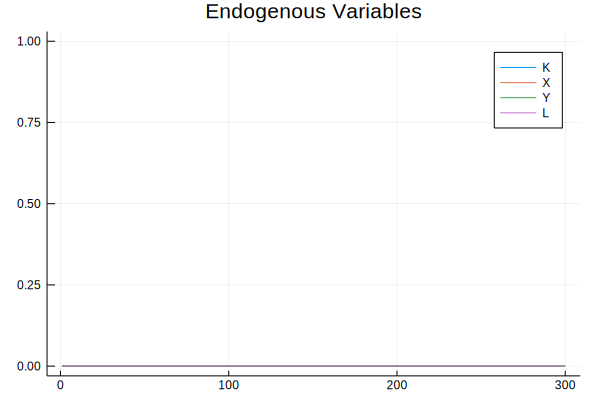

In [12]:
plot([X[1,:],Y[2,:],Y[1,:],Y[3,:]],title = "Endogenous Variables",labels = ["K","X","Y","L"])

The code above is summarized in a function State_Space which returns the matrices A,B,C

In [13]:
include("State_Space.jl")

State_Space (generic function with 1 method)

## Question 5


As instructed in class, we will postpone the estimation. We assume that the model above is indeed true data. Now, we need to shut all shocks.  First, we turn on one shock and shut off the others: 

In [14]:

#Only efficiency shocks
Xz= ones(5,T).* [0,0,0,0,0]
Yz = ones(4,T).*[0,0,0,0]
Sz = vcat(S[1:2,:], zeros(3,T))

for t=1:T
    if t>1
    Xz[:,t] = A*Xz[:,t-1]+ B*Sz[:,t]
    end
    Yz[:,t] = C*Xz[:,t]
end



#Only labor shocks
Xh= ones(5,T).* [0,0,0,0,0]
Yh = ones(4,T).*[0,0,0,0]
Sh = [zeros(2,T); S[3,:]' ; zeros(2,T)]


for t=1:T
    if t>1
    Xh[:,t] = A*Xh[:,t-1]+ B*Sh[:,t]
    end
    Yh[:,t] = C*Xh[:,t]
end


#Only investment shocks
Xx= ones(5,T).* [0,0,0,0,0]
Yx = ones(4,T).*[0,0,0,0]
Sx = [zeros(3,T); S[4,:]' ; zeros(1,T)]


for t=1:T
    if t>1
    Xx[:,t] = A*Xx[:,t-1]+ B*Sx[:,t]
    end
    Yx[:,t] = C*Xx[:,t]
end


#Only Government shocks
Xg= ones(5,T).* [0,0,0,0,0]
Yg = ones(4,T).*[0,0,0,0]
Sg = [zeros(4,T); S[5,:]']


for t=1:T
    if t>1
    Xg[:,t] = A*Xg[:,t-1]+ B*Sg[:,t]
    end
    Yg[:,t] = C*Xg[:,t]
end
plot(plot([Yz[1,:],Y[1,:]],title = "Only efficiency wedge",labels = ["Yz","Y"]),
    plot([Yh[1,:],Y[1,:]],title = "Only labor wedge",labels = ["Yh","Y"]),
    plot([Yx[1,:],Y[1,:]],title = "Only investment wedge",labels = ["Yx","Y"]),
plot([Yg[1,:],Y[1,:]],title = "Only government wedge",labels = ["Yg","Y"]))



UndefVarError: UndefVarError: C not defined

In [15]:
#No efficiency shocks
XZ= ones(5,T).* [0,0,0,0,0]
YZ = ones(4,T).*[0,0,0,0]
SZ = [zeros(2,T); S[3:5,:]]


for t=1:T
    if t>1
    XZ[:,t] = A*XZ[:,t-1]+ B*SZ[:,t]
    end
    YZ[:,t] = C*XZ[:,t]
end
plot([YZ[1,:],Y[1,:]],title = "No efficiency wedge",labels = ["YZ","Y"])

#No labor shocks
XH= ones(5,T).* [0,0,0,0,0]
YH = ones(4,T).*[0,0,0,0]
SH = [ S[1:2,:] ; zeros(1,T); S[4:5,:]]


for t=1:T
    if t>1
    XH[:,t] = A*XH[:,t-1]+ B*SH[:,t]
    end
    YH[:,t] = C*XH[:,t]
end
plot([YH[1,:],Y[1,:]],title = "No labor wedge",labels = ["YH","Y"])

#No investment shocks
XX= ones(5,T).* [0,0,0,0,0]
YX = ones(4,T).*[0,0,0,0]
SX = [ S[1:3,:] ; zeros(1,T); S[5,:]']


for t=1:T
    if t>1
    XX[:,t] = A*XX[:,t-1]+ B*SX[:,t]
    end
    YX[:,t] = C*XX[:,t]
end
plot([YX[1,:],Y[1,:]],title = "No investment wedge",labels = ["YX","Y"])

#No Government shocks
XG= ones(5,T).* [0,0,0,0,0]
YG = ones(4,T).*[0,0,0,0]
SG = [S[1:4,:];zeros(1,T)]


for t=1:T
    if t>1
    XG[:,t] = A*XG[:,t-1]+ B*SG[:,t]
    end
    YG[:,t] = C*XG[:,t]
end
plot([YG[1,:],Y[1,:]],title = "No government wedge",labels = ["YG","Y"])

plot(plot([YZ[1,:],Y[1,:]],title = "No efficiency wedge",labels = ["YZ","Y"]),
    plot([YH[1,:],Y[1,:]],title = "No labor wedge",labels = ["YH","Y"]),
    plot([YX[1,:],Y[1,:]],title = "No investment wedge",labels = ["YX","Y"]),
plot([YG[1,:],Y[1,:]],title = "No government wedge",labels = ["YG","Y"]))

UndefVarError: UndefVarError: C not defined

For our parametrization, Efficiency and labor wedges are the most important to explain the simulated path.  This is in line with our parameters. 